In [1]:
import os
os.chdir('/scratch/ws/gpu16-d3hack2019-DeepHydro/')
!pwd

/lustre/scratch2/ws/gpu16-d3hack2019-DeepHydro


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
from skimage.external import tifffile
import skimage
import scipy as sp
import scipy.fftpack

#!pip install --user seaborn
#!pip install --user statsmodels

import seaborn as sns
skimage.__version__

'0.14.2'

!pip install seaborn

In [5]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualize the errors

- Load the csv file

In [6]:
data_folder = '../output'
df_pred_name = 'df_pred.csv'

In [7]:
df_pred = pd.read_csv(os.path.join(data_folder, df_pred_name))
df_pred['error'] = df_pred.Q - df_pred.Q_pred

df_pred = df_pred.set_index(df_pred['Time'])
df_pred['month'] = pd.DatetimeIndex(df_pred.index).month
df_pred['year'] = pd.DatetimeIndex(df_pred.index).year
df_pred['day'] = pd.DatetimeIndex(df_pred.index).day

In [8]:
df_pred.head()
#df_pred.tail()

Unnamed: 0        Time      Q      Q_pred  Q_pred_sigma  \
Time                                                                  
1992-05-27       15487  1992-05-27  241.0  264.641479    124.778961   
1992-05-28       15488  1992-05-28  237.0  254.588593    136.049728   
1992-05-29       15489  1992-05-29  237.0  219.143951    123.719574   
1992-05-30       15490  1992-05-30  234.0  249.144928    130.232498   
1992-05-31       15491  1992-05-31  232.0  239.481812    174.397186   

            Q_pred_sigma_epi  Q_pred_sigma_alea      error  month  year  day  
Time                                                                          
1992-05-27         57.506847         110.737312 -23.641479      5  1992   27  
1992-05-28         69.547287         116.930336 -17.588593      5  1992   28  
1992-05-29         65.738037         104.809555  17.856049      5  1992   29  
1992-05-30         54.614456         118.227585 -15.144928      5  1992   30  
1992-05-31        112.488068         133.269714  -7.481812      5  1992   31

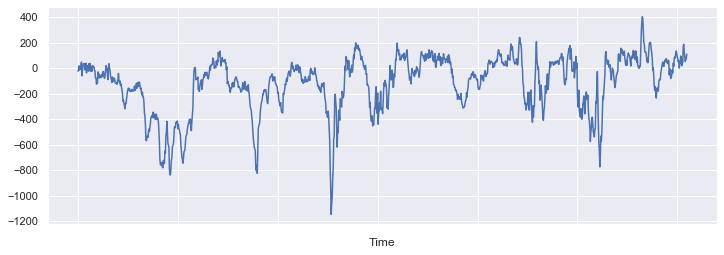

In [9]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
df_pred.error.plot()
plt.show()

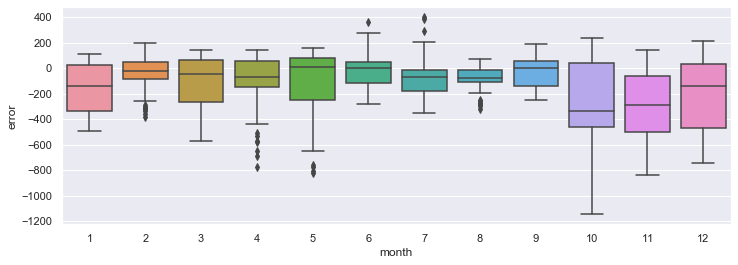

In [10]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
ax = sns.boxplot(x = 'month', y = 'error', data = df_pred)
plt.show()

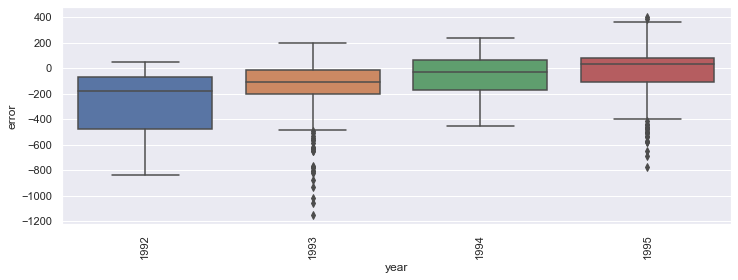

In [11]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
ax = sns.boxplot(x = 'year', y = 'error', data = df_pred)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


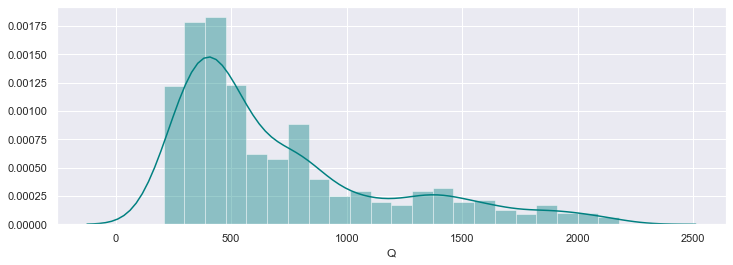

In [12]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots(sharex=True)
#series.Q.hist()

sns.distplot(df_pred["Q"] , color="teal", label="error")
plt.show()

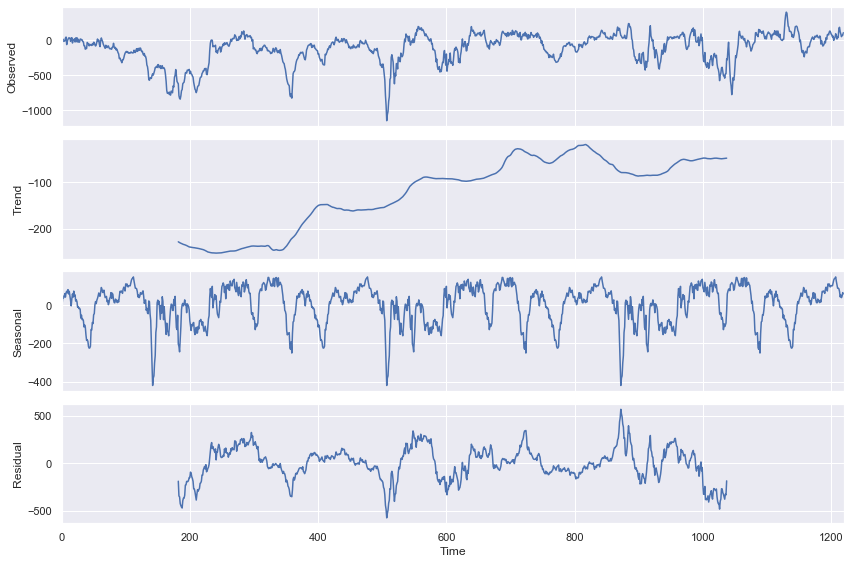

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(rc={'figure.figsize':(12, 8)})
result = seasonal_decompose(df_pred.error.values, model = 'additive', freq = 365)
fig = result.plot()
#plt.xticks(df_pred.index.values)
plt.show()

!pip install statsmodels

In [16]:
result.seasonal

array([-27.44422464,  11.1692954 ,  47.26639038, ...,  46.94204881,
        65.20278439,  58.95053048])

In [17]:
df_pred['Seasonal'] = result.seasonal
df_pred['Residual'] = result.resid
df_pred['Trend'] = result.trend

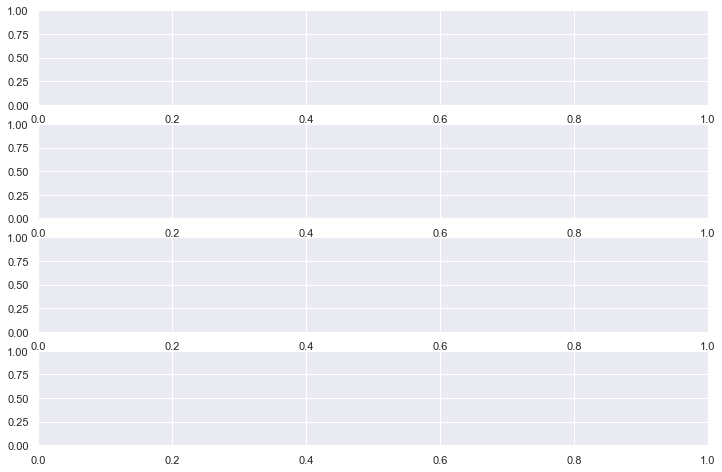

In [18]:
f, axes = plt.subplots(4, 1)

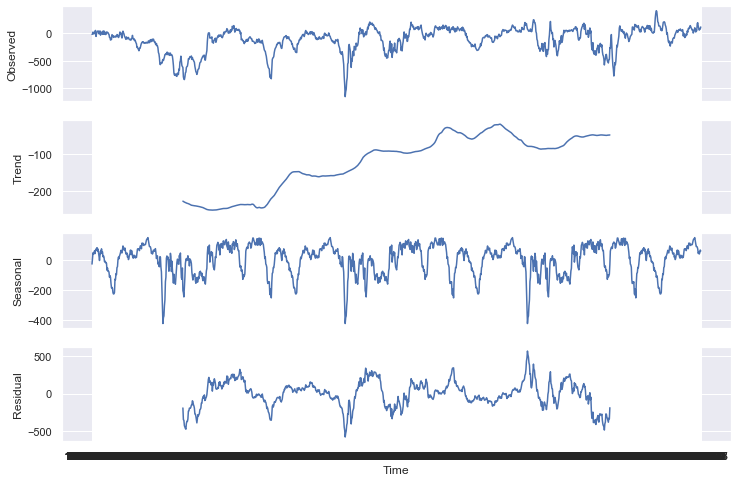

In [19]:
# takes a while

fig, axes = plt.subplots(4, 1, sharex=True)

axes[0].plot(df_pred.error)
axes[0].set_ylabel('Observed')

axes[1].plot(df_pred['Trend'])
axes[1].set_ylabel('Trend')

axes[2].plot(df_pred['Seasonal'])
axes[2].set_ylabel('Seasonal')

axes[3].plot(df_pred['Residual'])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')
plt.show()

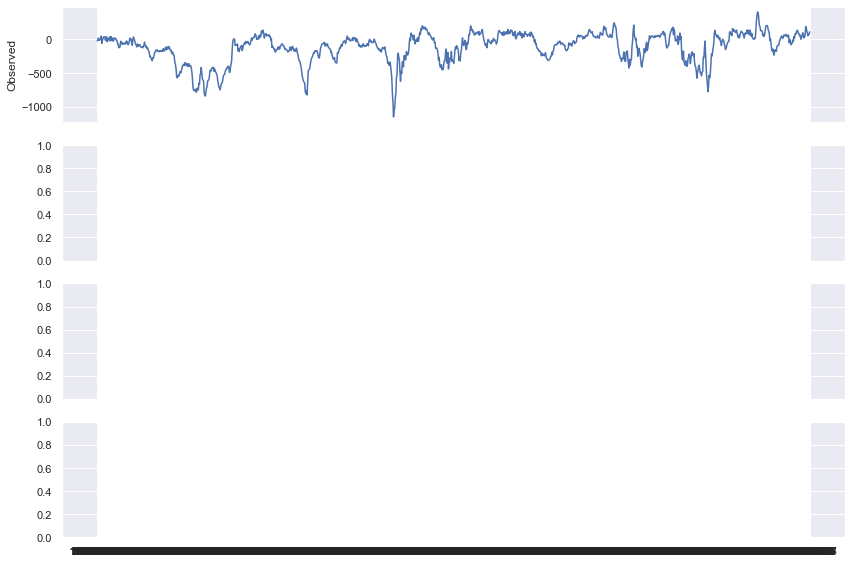

In [21]:
fig, axes = plt.subplots(4, 1, sharex=True)

axes[0].plot(df_pred.index, df_pred.error)
axes[0].set_ylabel('Observed')
fig.tight_layout()
plt.show() #plot(fig)

C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'PSD (dB)')

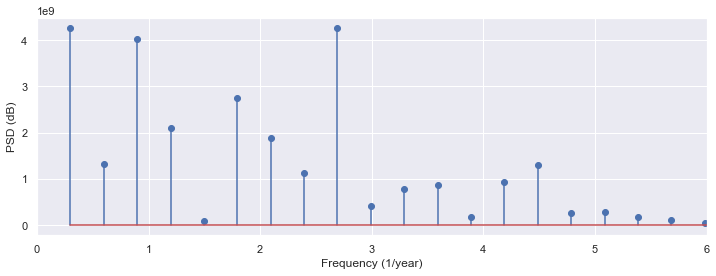

In [22]:
temp_fft = sp.fftpack.fft(df_pred.error)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 365)

# take only the positive frequencies
i = fftfreq > 0

sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.stem(fftfreq[i], temp_psd[i])
ax.set_xlim(0, 6)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')

In [60]:
#sns.set(rc={'figure.figsize':(12, 4)})
#g = sns.FacetGrid(df_pred, col = "month", hue = "year", col_wrap = 3, palette='RdYlBu', sharey = False)
#g = (g.map(plt.plot, "day", "error").add_legend())

In [26]:
get_ipython().magic('matplotlib inline')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

import netCDF4
import numpy as np
import os, sys
import pandas as pd
import seaborn as sns
import datetime

sns.set(style = "darkgrid")

from pyramid.arima import auto_arima

from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

ModuleNotFoundError: No module named 'pyramid.arima'

In [24]:
!pip install pyramid

### Load the data

In [27]:
#os.chdir("C:/Users/Elona.Gusho/Desktop/DeepHydro-master/")
data_folder = 'DeepHydro-master'
data_disc = '01_discharge.csv'

series = pd.read_csv(os.path.join(data_folder, data_disc))
series = series. drop('Unnamed: 0' , axis='columns')
series['Time'] = pd.to_datetime(series['Time'])
series = series.set_index('Time')

series['month'] = pd.DatetimeIndex(series.index).month
series['year'] = pd.DatetimeIndex(series.index).year
series['day'] = pd.DatetimeIndex(series.index).day

series.head()

FileNotFoundError: File b'DeepHydro-master\\01_discharge.csv' does not exist

## Summary Statistics 

### Description

In [ ]:
series.Q.describe()
# series.groupby('month', as_index=False).agg({"Q": "describe"})

### Create plots

#### Original time series

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
series.Q.plot()
plt.show()

### Original time series - divided monthly

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
g = sns.FacetGrid(series, col = "month", hue = "year", col_wrap = 3, palette='RdYlBu', sharey = False)
g = (g.map(plt.plot, "day", "Q").add_legend())

### Monthly boxplot

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
ax = sns.boxplot(x = 'month', y = 'Q', data = series)
plt.show()

### Yearly boxplot

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
ax = sns.boxplot(x = 'year', y = 'Q', data = series)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [ ]:
df2_mean = pd.pivot_table(series, index = 'year', columns = 'month', values = 'Q', aggfunc=np.mean)
df2_std = pd.pivot_table(series, index = 'year', columns = 'month', values = 'Q', aggfunc=np.std)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.subplots_adjust(hspace = 6)
fig.suptitle('Aggregated data on month and year')

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Mean value for the monthly aggregation')
sns.heatmap(df2_mean, cmap = "YlGnBu")
plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Std value for the monthly aggregation')
sns.heatmap(df2_std, cmap = "YlGnBu")

### Histogram 

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots(sharex=True)
#series.Q.hist()

sns.distplot(series["Q"] , color="teal", label="Q")
plt.show()

#fig, ax = plt.subplots()
#fig.set_size_inches((12,4))
#series.Q.plot(kind='kde')
#plt.show()

### Lagged plot

In [ ]:
from pandas.plotting import lag_plot
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
lag_plot(series.Q,  ax = ax)

## Autocorrleation and partial Autocorrelation

### Autocorrelation plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
x = plot_acf(series.Q.values.squeeze(),  ax = ax, lags=500)

### Partial Autocorrelation

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
x = plot_pacf(series.Q.values.squeeze(), ax = ax, lags = 15)

## Time series decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(rc={'figure.figsize':(12, 8)})
result = seasonal_decompose(series.Q.values, model = 'additive', freq = 365)
fig = result.plot()
plt.show()

### Detrend by Differencing

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
plt.plot(series.Q.diff())

## Frequency domain visualization

In [ ]:
import scipy as sp
import scipy.fftpack

In [ ]:
temp_fft = sp.fftpack.fft(series.Q)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / 365)

# take only the positive frequencies
i = fftfreq > 0

In [ ]:
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(fftfreq[i], temp_psd[i])
ax.set_xlim(0, 7)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')

In [ ]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 5] = 0

In [ ]:
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots(1, 1)
date = series.index
ax.plot_date(date, series.Q,  lw = .5)
ax.plot_date(date, temp_slow, '-')
ax.set_xlim(datetime.date(1998, 1, 1),
            datetime.date(2016, 1, 1))
ax.set_xlabel('Date')
ax.set_ylabel('Q')